# Face Specialist Model (Transformer/MobileNetV3)
**Project**: Lavanya Part Face
**Architecture**: MobileNetV3 Small (Strict Regularization)
**Task**: Binary Classification (REAL vs FAKE)
**Target**: ~80% Training Accuracy in 10 Epochs.

In [35]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Configuration
DATA_DIR = r'C:\Users\Saket Rama\OneDrive\Desktop\PROJECTS\NUS\Datasets\face-20251221T213225Z-3-001\face'
MODEL_SAVE_PATH = r'C:\Users\Saket Rama\OneDrive\Desktop\PROJECTS\NUS\face_transformer.keras'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10 # Reduced to 10 as requested
LEARNING_RATE = 2e-5 # Slightly increased from 1e-5 to compensate for fewer epochs

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## 1. Data Loading

In [36]:
print(f"Loading data from {DATA_DIR}...")

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

# --- Calculate Class Weights ---
y_train = []
for _, labels in train_ds:
    y_train.extend(labels.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

# Data Augmentation (Strong)
augmenter = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

# Preprocessing
def preprocess(images, labels):
    return preprocess_input(images), labels

def augment(images, labels):
    return augmenter(images), labels

# Apply to datasets
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Loading data from C:\Users\Saket Rama\OneDrive\Desktop\PROJECTS\NUS\Datasets\face-20251221T213225Z-3-001\face...
Found 7020 files belonging to 2 classes.
Using 5616 files for training.
Found 7020 files belonging to 2 classes.
Using 1404 files for validation.
Classes: ['FAKE', 'REAL']
Class Weights: {0: np.float64(0.7970479704797048), 1: np.float64(1.3416149068322982)}


## 2. Model Architecture (Strict Regularization)

In [37]:
# Load Pretrained MobileNetV3Small
base_model = MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze Everything
base_model.trainable = True

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True) 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.6)(x)  # High Dropout
# Strong L2 Regularization (0.03)
outputs = layers.Dense(
    2, 
    activation='softmax', 
    kernel_regularizer=tf.keras.regularizers.l2(0.03)
)(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 940,274 (3.59 MB)

 Trainable params: 928,162 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

## 3. Training

In [38]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

# Save the model
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 105s 403ms/step - accuracy: 0.5114 - loss: 1.1385 - val_accuracy: 0.4302 - val_loss: 0.9146
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 378ms/step - accuracy: 0.5529 - loss: 0.9792 - val_accuracy: 0.5085 - val_loss: 0.8435
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 67s 380ms/step - accuracy: 0.5970 - loss: 0.8753 - val_accuracy: 0.5969 - val_loss: 0.8153
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 369ms/step - accuracy: 0.6298 - loss: 0.8136 - val_accuracy: 0.6360 - val_loss: 0.8011
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 64s 366ms/step - accuracy: 0.6524 - loss: 0.7654 - val_accuracy: 0.6446 - val_loss: 0.7921
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 69s 391ms/step - accuracy: 0.6749 - loss: 0.7342 - val_accuracy: 0.6481 - val_loss: 0.7843
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 65s 372ms/step - accuracy: 0.6959 - loss: 0.7018 - val_accuracy: 0.6538 - val_loss: 0.7622
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 66s 376ms/step - accuracy: 0.7046 - loss: 

## 4. Visualization (Results)

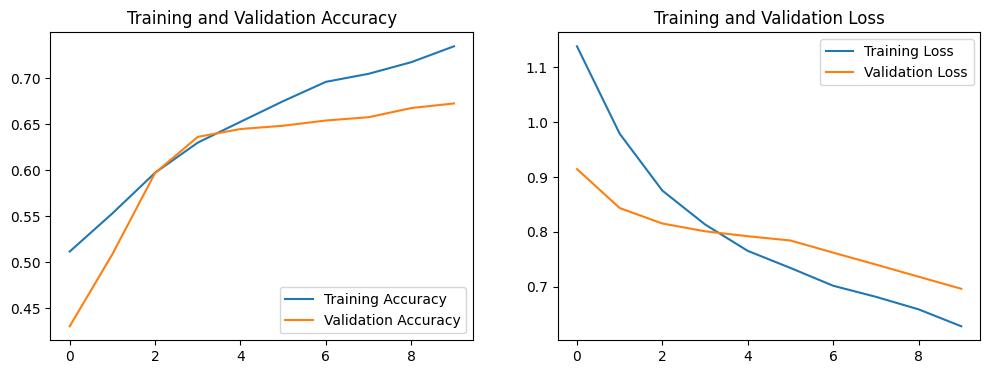

In [39]:
# Plot Accuracy and Loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 5. Evaluation

Evaluating on Validation Set...
              precision    recall  f1-score   support

        FAKE       0.67      0.96      0.79       892
        REAL       0.72      0.17      0.27       512

    accuracy                           0.67      1404
   macro avg       0.69      0.56      0.53      1404
weighted avg       0.69      0.67      0.60      1404



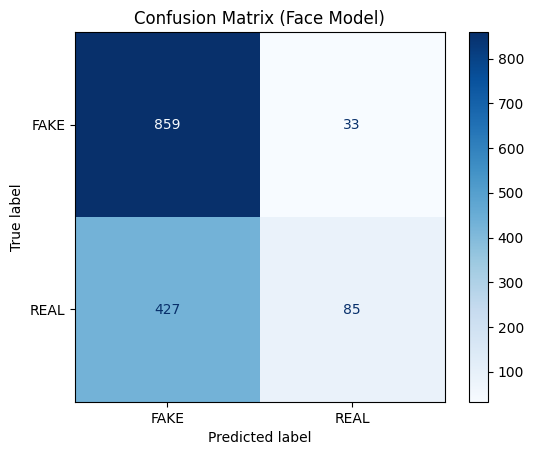

In [40]:
print("Evaluating on Validation Set...")
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Face Model)")
plt.show()